# **1. LIBRARY**

In [1]:
import os
import pickle
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K
import tensorflow as tf
import keras
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from scipy.spatial.distance import directed_hausdorff
from keras.saving import load_model
from keras.losses import BinaryCrossentropy
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore")

# **2. METRICS**

In [2]:
def bce_loss(y_true, y_pred):
    epsilon = 1e-9
    bce = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    return bce

In [3]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred_bin = K.cast((y_pred >= 0.5), tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred_bin), axis=[1])
    combination = K.sum(y_true, [1]) + K.sum(y_pred_bin, [1])
    dice = K.mean((intersection + intersection + smooth) / (combination + smooth), axis=0)
    return dice

In [4]:
def iou_coef(y_true, y_pred, smooth=1):
    y_pred_bin = K.cast((y_pred >= 0.5), tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred_bin), axis=[1])
    union = K.sum(y_true, [1]) + K.sum(y_pred_bin, [1]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [5]:
def mean_accuracy(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(y_true)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(y_pred)[0], -1) >= 0.5, dtype=int)
    accuracy_list = []
    for i in range(np.shape(y_true)[0]):
        accuracy = accuracy_score(y_true[i], y_pred[i])
        accuracy_list.append(accuracy)
    return np.mean(accuracy_list)

In [6]:
def mean_precision(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(y_true)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(y_pred)[0], -1) >= 0.5, dtype=int)
    precision_list = []
    for i in range(np.shape(y_true)[0]):
        precision = precision_score(y_true[i], y_pred[i])
        precision_list.append(precision)
    return np.mean(precision_list)

In [7]:
def mean_recall(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(y_true)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(y_pred)[0], -1) >= 0.5, dtype=int)
    recall_list = []
    for i in range(np.shape(y_true)[0]):
        recall = recall_score(y_true[i], y_pred[i])
        recall_list.append(recall)
    return np.mean(recall_list)

In [8]:
def mean_f1score(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(y_true)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(y_pred)[0], -1) >= 0.5, dtype=int)
    f1score_list = []
    for i in range(np.shape(y_true)[0]):
        f1score = f1_score(y_true[i], y_pred[i])
        f1score_list.append(f1score)
    return np.mean(f1score_list)

In [9]:
def mean_specificity(y_true, y_pred):
    y_true = np.array(y_true.reshape(np.shape(y_true)[0], -1), dtype=int)
    y_pred = np.array(y_pred.reshape(np.shape(y_pred)[0], -1) >= 0.5, dtype=int)
    specificity_list = []
    for i in range(np.shape(y_true)[0]):
        TN = np.sum((y_true[i] == 0) & (y_pred[i] == 0))
        FP = np.sum((y_true[i] == 0) & (y_pred[i] == 1))
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_list.append(specificity)
    return np.mean(specificity_list)

# **3. MODEL**

In [ ]:
unet = load_model('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/1/model/U-Net.h5')

with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/1/model/weights.pkl', 'rb') as f:
    weights_unet = pickle.load(f)

with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/1/history/train_loss.pkl', 'rb') as f:
    history_train_loss_unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/1/history/train_dice.pkl', 'rb') as f:
    history_train_dice_unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/1/history/train_iou.pkl', 'rb') as f:
    history_train_iou_unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/1/history/val_loss.pkl', 'rb') as f:
    history_val_loss_unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/1/history/val_dice.pkl', 'rb') as f:
    history_val_dice_unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/1/history/val_iou.pkl', 'rb') as f:
    history_val_iou_unet = pickle.load(f)

In [ ]:
attunet = load_model('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/2/model/Attention_U-Net.h5')

with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/2/model/weights.pkl', 'rb') as f:
    weights_attunet = pickle.load(f)

with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/2/history/train_loss.pkl', 'rb') as f:
    history_train_loss_attunet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/2/history/train_dice.pkl', 'rb') as f:
    history_train_dice_attunet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/2/history/train_iou.pkl', 'rb') as f:
    history_train_iou_attunet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/2/history/val_loss.pkl', 'rb') as f:
    history_val_loss_attunet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/2/history/val_dice.pkl', 'rb') as f:
    history_val_dice_attunet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/2/history/val_iou.pkl', 'rb') as f:
    history_val_iou_attunet = pickle.load(f)

In [ ]:
unetpp = load_model('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/3/model/U-Net++.h5')

with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/3/model/weights.pkl', 'rb') as f:
    weights_unetpp = pickle.load(f)

with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/3/history/train_loss.pkl', 'rb') as f:
    history_train_loss_unetpp = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/3/history/train_dice.pkl', 'rb') as f:
    history_train_dice_unetpp = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/3/history/train_iou.pkl', 'rb') as f:
    history_train_iou_unetpp = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/3/history/val_loss.pkl', 'rb') as f:
    history_val_loss_unetpp = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/3/history/val_dice.pkl', 'rb') as f:
    history_val_dice_unetpp = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/3/history/val_iou.pkl', 'rb') as f:
    history_val_iou_unetpp = pickle.load(f)

In [ ]:
r2unet = load_model('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/4/model/R2U-Net.h5')

with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/4/model/weights.pkl', 'rb') as f:
    weights_r2unet = pickle.load(f)

with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/4/history/train_loss.pkl', 'rb') as f:
    history_train_loss_r2unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/4/history/train_dice.pkl', 'rb') as f:
    history_train_dice_r2unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/4/history/train_iou.pkl', 'rb') as f:
    history_train_iou_r2unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/4/history/val_loss.pkl', 'rb') as f:
    history_val_loss_r2unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/4/history/val_dice.pkl', 'rb') as f:
    history_val_dice_r2unet = pickle.load(f)
with open('/kaggle/input/dermoscopic-lesion-segmentation-model/keras/default/4/history/val_iou.pkl', 'rb') as f:
    history_val_iou_r2unet = pickle.load(f)

# **4. DATASET**

In [14]:
img_size = 128

In [15]:
x_test = np.load('/kaggle/input/dermoscopic-lesion/train/images.npy')
y_test = (np.load('/kaggle/input/dermoscopic-lesion/train/masks.npy') >= 0.5).astype(np.float32).reshape(-1, img_size, img_size)

print(np.shape(x_test))
print(np.shape(y_test))

(2074, 128, 128, 3)
(2074, 128, 128)


# **5. RESULT**

## **5.1. Training Curve**

### **5.1.1. Train Loss**

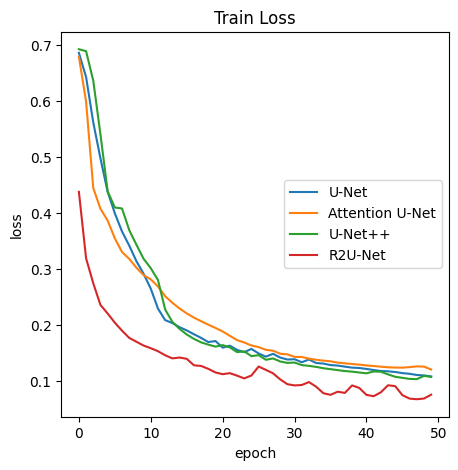

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(history_train_loss_unet)
plt.plot(history_train_loss_attunet)
plt.plot(history_train_loss_unetpp)
plt.plot(history_train_loss_r2unet)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Train Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.2. Train Dice**

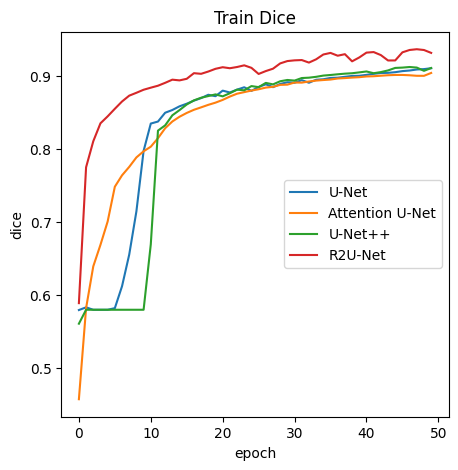

In [17]:
plt.figure(figsize=(5, 5))
plt.plot(history_train_dice_unet)
plt.plot(history_train_dice_attunet)
plt.plot(history_train_dice_unetpp)
plt.plot(history_train_dice_r2unet)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Train Dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.3. Train IoU**

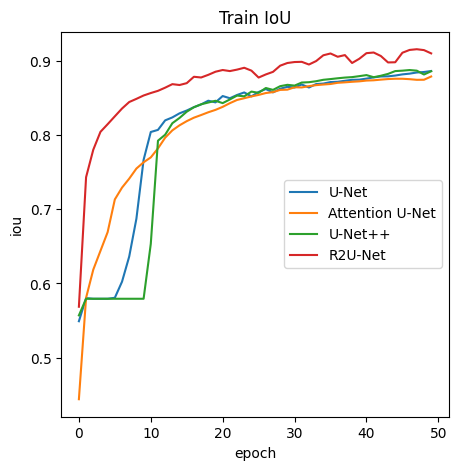

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(history_train_iou_unet)
plt.plot(history_train_iou_attunet)
plt.plot(history_train_iou_unetpp)
plt.plot(history_train_iou_r2unet)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Train IoU')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.4. Val Loss**

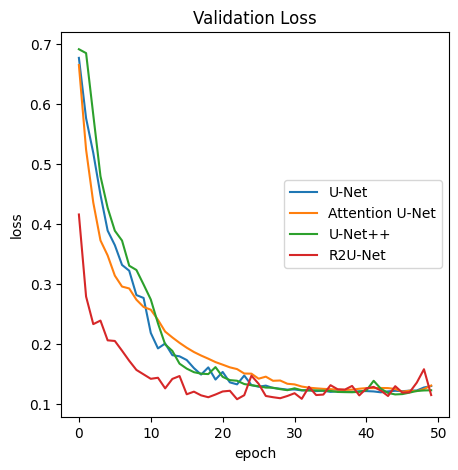

In [19]:
plt.figure(figsize=(5, 5))
plt.plot(history_val_loss_unet)
plt.plot(history_val_loss_attunet)
plt.plot(history_val_loss_unetpp)
plt.plot(history_val_loss_r2unet)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.5. Val Dice**

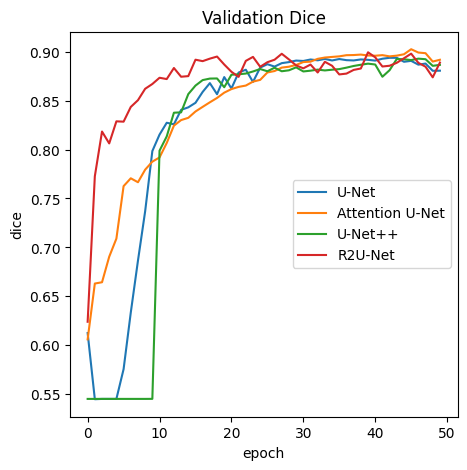

In [20]:
plt.figure(figsize=(5, 5))
plt.plot(history_val_dice_unet)
plt.plot(history_val_dice_attunet)
plt.plot(history_val_dice_unetpp)
plt.plot(history_val_dice_r2unet)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Validation Dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

### **5.1.6. Val IoU**

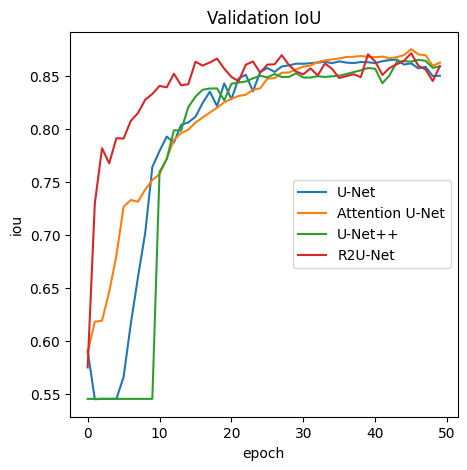

In [21]:
plt.figure(figsize=(5, 5))
plt.plot(history_val_iou_unet)
plt.plot(history_val_iou_attunet)
plt.plot(history_val_iou_unetpp)
plt.plot(history_val_iou_r2unet)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Validation IoU')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net'], loc='center right')
plt.show()
plt.close()

## **5.2. Performance on Testset**

### **5.2.1. Test Results Summary**

In [22]:
mask_unet = unet.predict(x_test, verbose=True).reshape(-1, img_size, img_size)
mask_attunet = attunet.predict(x_test, verbose=True).reshape(-1, img_size, img_size)
mask_unetpp = unetpp.predict(x_test, verbose=True).reshape(-1, img_size, img_size)
mask_r2unet = r2unet.predict(x_test, verbose=True).reshape(-1, img_size, img_size)

print(np.shape(mask_unet))
print(np.shape(mask_attunet))
print(np.shape(mask_unetpp))
print(np.shape(mask_r2unet))

65/65 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 791ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 47s 715ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step
(2074, 128, 128)
(2074, 128, 128)
(2074, 128, 128)
(2074, 128, 128)


In [23]:
print('Calculating metrics for U-Net...', end=' ')
loss_unet = bce_loss(y_test, mask_unet)
dice_unet = np.mean(dice_coef(y_test, mask_unet))
iou_unet = np.mean(iou_coef(y_test, mask_unet))
accuracy_unet = mean_accuracy(y_test, mask_unet)
precision_unet = mean_precision(y_test, mask_unet)
recall_unet = mean_recall(y_test, mask_unet)
f1score_unet = mean_f1score(y_test, mask_unet)
specificity_unet = mean_specificity(y_test, mask_unet)
print('Done !')

print('Calculating metrics for Attention U-Net...', end=' ')
loss_attunet = bce_loss(y_test, mask_attunet)
dice_attunet = np.mean(dice_coef(y_test, mask_attunet))
iou_attunet = np.mean(iou_coef(y_test, mask_attunet))
accuracy_attunet = mean_accuracy(y_test, mask_attunet)
precision_attunet = mean_precision(y_test, mask_attunet)
recall_attunet = mean_recall(y_test, mask_attunet)
f1score_attunet = mean_f1score(y_test, mask_attunet)
specificity_attunet = mean_specificity(y_test, mask_attunet)
print('Done !')

print('Calculating metrics for U-Net++...', end=' ')
loss_unetpp = bce_loss(y_test, mask_unetpp)
dice_unetpp = np.mean(dice_coef(y_test, mask_unetpp))
iou_unetpp = np.mean(iou_coef(y_test, mask_unetpp))
accuracy_unetpp = mean_accuracy(y_test, mask_unetpp)
precision_unetpp = mean_precision(y_test, mask_unetpp)
recall_unetpp = mean_recall(y_test, mask_unetpp)
f1score_unetpp = mean_f1score(y_test, mask_unetpp)
specificity_unetpp = mean_specificity(y_test, mask_unetpp)
print('Done !')

print('Calculating metrics for R2U-Net...', end=' ')
loss_r2unet = bce_loss(y_test, mask_r2unet)
dice_r2unet = np.mean(dice_coef(y_test, mask_r2unet))
iou_r2unet = np.mean(iou_coef(y_test, mask_r2unet))
accuracy_r2unet = mean_accuracy(y_test, mask_r2unet)
precision_r2unet = mean_precision(y_test, mask_r2unet)
recall_r2unet = mean_recall(y_test, mask_r2unet)
f1score_r2unet = mean_f1score(y_test, mask_r2unet)
specificity_r2unet = mean_specificity(y_test, mask_r2unet)
print('Done !')

Calculating metrics for U-Net... Done !
Calculating metrics for Attention U-Net... Done !
Calculating metrics for U-Net++... Done !
Calculating metrics for R2U-Net... Done !


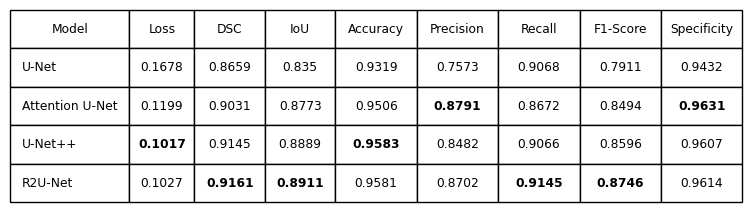

In [24]:
models = ['U-Net', 'Attention U-Net', 'U-Net++', 'R2U-Net']

loss = []
loss.append(str(round(loss_unet, 4)))
loss.append(str(round(loss_attunet, 4)))
loss.append(str(round(loss_unetpp, 4)))
loss.append(str(round(loss_r2unet, 4)))

dice = []
dice.append(str(round(dice_unet, 4)))
dice.append(str(round(dice_attunet, 4)))
dice.append(str(round(dice_unetpp, 4)))
dice.append(str(round(dice_r2unet, 4)))

iou = []
iou.append(str(round(iou_unet, 4)))
iou.append(str(round(iou_attunet, 4)))
iou.append(str(round(iou_unetpp, 4)))
iou.append(str(round(iou_r2unet, 4)))

accuracy = []
accuracy.append(str(round(accuracy_unet, 4)))
accuracy.append(str(round(accuracy_attunet, 4)))
accuracy.append(str(round(accuracy_unetpp, 4)))
accuracy.append(str(round(accuracy_r2unet, 4)))

precision = []
precision.append(str(round(precision_unet, 4)))
precision.append(str(round(precision_attunet, 4)))
precision.append(str(round(precision_unetpp, 4)))
precision.append(str(round(precision_r2unet, 4)))

recall = []
recall.append(str(round(recall_unet, 4)))
recall.append(str(round(recall_attunet, 4)))
recall.append(str(round(recall_unetpp, 4)))
recall.append(str(round(recall_r2unet, 4)))

f1score = []
f1score.append(str(round(f1score_unet, 4)))
f1score.append(str(round(f1score_attunet, 4)))
f1score.append(str(round(f1score_unetpp, 4)))
f1score.append(str(round(f1score_r2unet, 4)))

specificity = []
specificity.append(str(round(specificity_unet, 4)))
specificity.append(str(round(specificity_attunet, 4)))
specificity.append(str(round(specificity_unetpp, 4)))
specificity.append(str(round(specificity_r2unet, 4)))

df = pd.DataFrame({'Model': models, 'Loss': loss, 'DSC': dice, 'IoU': iou, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1score, 'Specificity': specificity})

fig, ax = plt.subplots(figsize=(7, 1))
ax.axis("tight")
ax.axis("off")

table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc="center", loc="center", colWidths=[0.15, 0.1, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15])

col_widths = [0.22, 0.12, 0.13, 0.13, 0.15, 0.15, 0.15, 0.15, 0.15]
for i, width in enumerate(col_widths):
    for j in range(5):
        table[(j, i)].set_width(width)
        table[(j, i)].set_height(0.5)

for (i, j), cell in table._cells.items():
    if i == 0: 
        cell.set_text_props(ha="center")
    elif j == 0:
        cell.set_text_props(ha="left")
    elif j == 1:
        cell.set_text_props(ha="center")
        if i == 3:
            cell.set_text_props(weight="bold", color="black")
    elif j == 2:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 3:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 4:
        cell.set_text_props(ha="center")
        if i == 3:
            cell.set_text_props(weight="bold", color="black")
    elif j == 5:
        cell.set_text_props(ha="center")
        if i == 2:
            cell.set_text_props(weight="bold", color="black")
    elif j == 6:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 7:
        cell.set_text_props(ha="center")
        if i == 4:
            cell.set_text_props(weight="bold", color="black")
    elif j == 8:
        cell.set_text_props(ha="center")
        if i == 2:
            cell.set_text_props(weight="bold", color="black")

table.auto_set_font_size(False)
table.set_fontsize(8.8)
            
plt.show()

### **5.2.2. Visualization**

In [25]:
def save_image(path, image, name):
    image = (image * 255).astype(np.uint8)
    save_path = os.path.join(path, name + '.png')
    cv2.imwrite(save_path, image)

In [26]:
def read_image(path, name):
    read_path = os.path.join(path, name + '.png')
    image = cv2.imread(read_path)
    return image

In [32]:
idx = [0, 1, 5, 3]

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', x_test[idx[0]], str(idx[0]))
save_image('/kaggle/working/', x_test[idx[1]], str(idx[1]))
save_image('/kaggle/working/', x_test[idx[2]], str(idx[2]))
save_image('/kaggle/working/', x_test[idx[3]], str(idx[3]))
image_1 = read_image('/kaggle/working/', str(idx[0]))
image_2 = read_image('/kaggle/working/', str(idx[1]))
image_3 = read_image('/kaggle/working/', str(idx[2]))
image_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', y_test[idx[0]], str(idx[0]))
save_image('/kaggle/working/', y_test[idx[1]], str(idx[1]))
save_image('/kaggle/working/', y_test[idx[2]], str(idx[2]))
save_image('/kaggle/working/', y_test[idx[3]], str(idx[3]))
mask_1 = read_image('/kaggle/working/', str(idx[0]))
mask_2 = read_image('/kaggle/working/', str(idx[1]))
mask_3 = read_image('/kaggle/working/', str(idx[2]))
mask_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', mask_unet[idx[0]] >= 0.5, str(idx[0]))
save_image('/kaggle/working/', mask_unet[idx[1]] >= 0.5, str(idx[1]))
save_image('/kaggle/working/', mask_unet[idx[2]] >= 0.5, str(idx[2]))
save_image('/kaggle/working/', mask_unet[idx[3]] >= 0.5, str(idx[3]))
mask_unet_1 = read_image('/kaggle/working/', str(idx[0]))
mask_unet_2 = read_image('/kaggle/working/', str(idx[1]))
mask_unet_3 = read_image('/kaggle/working/', str(idx[2]))
mask_unet_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', mask_attunet[idx[0]] >= 0.5, str(idx[0]))
save_image('/kaggle/working/', mask_attunet[idx[1]] >= 0.5, str(idx[1]))
save_image('/kaggle/working/', mask_attunet[idx[2]] >= 0.5, str(idx[2]))
save_image('/kaggle/working/', mask_attunet[idx[3]] >= 0.5, str(idx[3]))
mask_attunet_1 = read_image('/kaggle/working/', str(idx[0]))
mask_attunet_2 = read_image('/kaggle/working/', str(idx[1]))
mask_attunet_3 = read_image('/kaggle/working/', str(idx[2]))
mask_attunet_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', mask_unetpp[idx[0]] >= 0.5, str(idx[0]))
save_image('/kaggle/working/', mask_unetpp[idx[1]] >= 0.5, str(idx[1]))
save_image('/kaggle/working/', mask_unetpp[idx[2]] >= 0.5, str(idx[2]))
save_image('/kaggle/working/', mask_unetpp[idx[3]] >= 0.5, str(idx[3]))
mask_unetpp_1 = read_image('/kaggle/working/', str(idx[0]))
mask_unetpp_2 = read_image('/kaggle/working/', str(idx[1]))
mask_unetpp_3 = read_image('/kaggle/working/', str(idx[2]))
mask_unetpp_4 = read_image('/kaggle/working/', str(idx[3]))

!rm -rf /kaggle/working/*
save_image('/kaggle/working/', mask_r2unet[idx[0]] >= 0.5, str(idx[0]))
save_image('/kaggle/working/', mask_r2unet[idx[1]] >= 0.5, str(idx[1]))
save_image('/kaggle/working/', mask_r2unet[idx[2]] >= 0.5, str(idx[2]))
save_image('/kaggle/working/', mask_r2unet[idx[3]] >= 0.5, str(idx[3]))
mask_r2unet_1 = read_image('/kaggle/working/', str(idx[0]))
mask_r2unet_2 = read_image('/kaggle/working/', str(idx[1]))
mask_r2unet_3 = read_image('/kaggle/working/', str(idx[2]))
mask_r2unet_4 = read_image('/kaggle/working/', str(idx[3]))

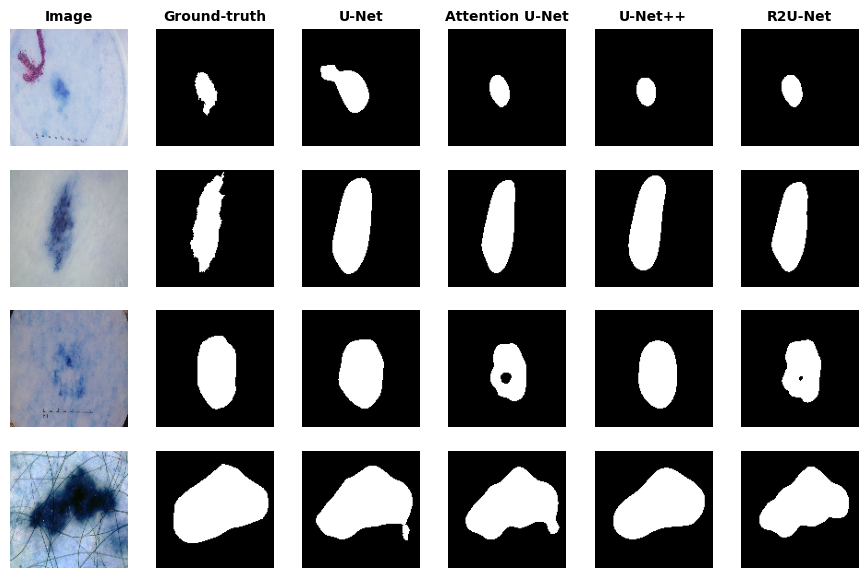

In [33]:
fig, axs = plt.subplots(4, 6, figsize=(11, 7))

for ax in axs.flat:
    ax.axis('off')

axs[0, 0].set_title('Image', fontsize=10, fontweight='bold')
axs[0, 0].imshow(image_1, cmap='gray')
axs[1, 0].imshow(image_2, cmap='gray')
axs[2, 0].imshow(image_3, cmap='gray')
axs[3, 0].imshow(image_4, cmap='gray')

axs[0, 1].set_title('Ground-truth', fontsize=10, fontweight='bold')
axs[0, 1].imshow(mask_1, cmap='gray')
axs[1, 1].imshow(mask_2, cmap='gray')
axs[2, 1].imshow(mask_3, cmap='gray')
axs[3, 1].imshow(mask_4, cmap='gray')

axs[0, 2].set_title('U-Net', fontsize=10, fontweight='bold')
axs[0, 2].imshow(mask_unet_1, cmap='gray')
axs[1, 2].imshow(mask_unet_2, cmap='gray')
axs[2, 2].imshow(mask_unet_3, cmap='gray')
axs[3, 2].imshow(mask_unet_4, cmap='gray')

axs[0, 3].set_title('Attention U-Net', fontsize=10, fontweight='bold')
axs[0, 3].imshow(mask_attunet_1, cmap='gray')
axs[1, 3].imshow(mask_attunet_2, cmap='gray')
axs[2, 3].imshow(mask_attunet_3, cmap='gray')
axs[3, 3].imshow(mask_attunet_4, cmap='gray')

axs[0, 4].set_title('U-Net++', fontsize=10, fontweight='bold')
axs[0, 4].imshow(mask_unetpp_1, cmap='gray')
axs[1, 4].imshow(mask_unetpp_2, cmap='gray')
axs[2, 4].imshow(mask_unetpp_3, cmap='gray')
axs[3, 4].imshow(mask_unetpp_4, cmap='gray')

axs[0, 5].set_title('R2U-Net', fontsize=10, fontweight='bold')
axs[0, 5].imshow(mask_r2unet_1, cmap='gray')
axs[1, 5].imshow(mask_r2unet_2, cmap='gray')
axs[2, 5].imshow(mask_r2unet_3, cmap='gray')
axs[3, 5].imshow(mask_r2unet_4, cmap='gray')